###Installation of the transformers

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.5 MB/s eta 0:00:00


In [2]:
#@title Setup & Config
#importing important libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
path='/split/' 
df_train=pd.read_csv(path+'cannbis_Train.csv')
df_test=pd.read_csv(path+'cannabis_Test.csv')
# create an empty DataFrame with 'label' and 'text' columns
df_train.columns=['Label', 'match_sentence']
df_test.columns=['Label', 'match_sentence']


In [5]:
df_train.head()

,Label,match_sentence
0,0,WET READ VERSION #1 __________________________...
1,1,"SOCIAL HISTORY: Tobacco one pack per day, occa..."
2,1,"Over the last week he has had little appetite,..."
3,0,"P: Continue to monitor, check CBG this a.m."
4,1,Experimentation with marijuana.


In [6]:
df_test.head()

,Label,match_sentence
0,0,Rate increased by 2 this afternoon following a...
1,0,Spoke with her about starting plans to get inf...
2,1,"Denies any ETOH, occassional marijuana, used t..."
3,1,"[**3-30**] drinks per week, smokes 1 ppd x 5 y..."
4,2,The patient has a positive history of alcohol ...


In [7]:
df_train.info(),df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Label           1007 non-null   int64 
 1   match_sentence  1007 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Label           253 non-null    int64 
 1   match_sentence  253 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.1+ KB


(None, None)

In [8]:
df_train.shape,df_test.shape

((1007, 2), (253, 2))

Data Processing 

##Create the BERT Pre trained model tokenizer

In [9]:

tokenizer=transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [10]:
sample_txt='The squirrel is climbing to the tree! How cute!!:)'

In [11]:
tokens=tokenizer.tokenize(sample_txt)

In [12]:
token_ids=tokenizer.convert_tokens_to_ids(tokens)

In [13]:
print(tokens)
print(len(token_ids))
print(token_ids)

['The', 'squirrel', 'is', 'climbing', 'to', 'the', 'tree', '!', 'How', 'cute', '!', '!', ':', ')']
14
[1109, 25817, 1110, 8259, 1106, 1103, 2780, 106, 1731, 10509, 106, 106, 131, 114]


###Special tokens as [SEP],[CLS],[UNK]

In [14]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [15]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [16]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [17]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [18]:
encoding=tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [19]:
encoding['input_ids']

tensor([[  101,  1109, 25817,  1110,  8259,  1106,  1103,  2780,   106,  1731,
         10509,   106,   106,   131,   114,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [20]:
len(encoding['input_ids'][0])

32

In [21]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

###Selecting the text max length

In [22]:
token_lens=[]
for txt in df_train.match_sentence:
  tokens=tokenizer.encode(txt,max_length=512)
  token_lens.append(len(tokens))

<ipython-input-23-e522afe1f942>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


<Axes: ylabel='Density'>

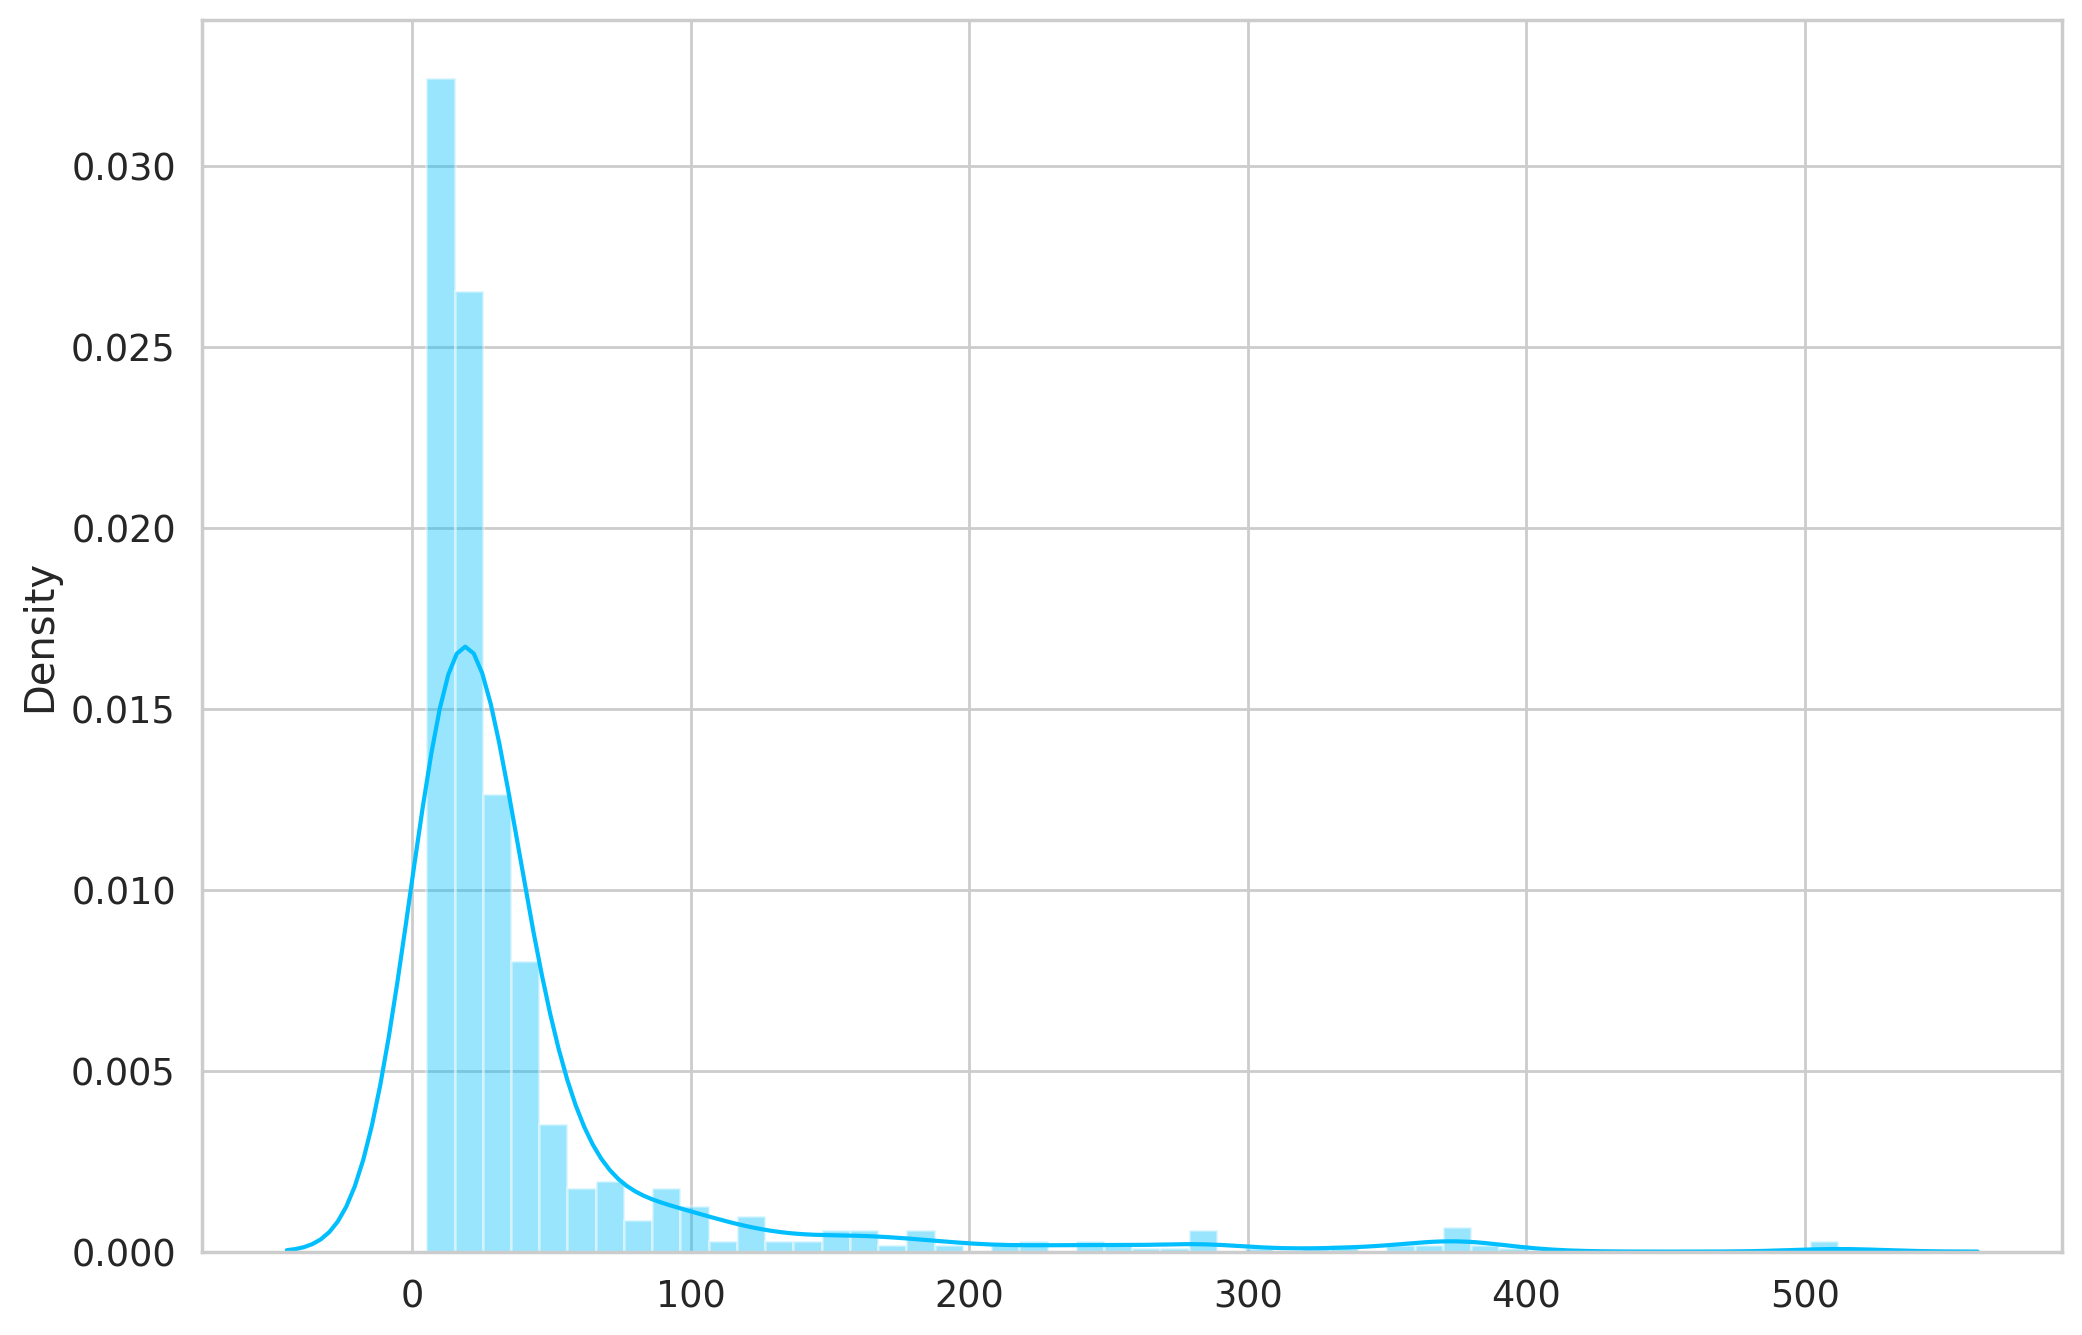

In [23]:
sns.distplot(token_lens)

In [24]:
#CannabisClassData class process the data
#uses BERT tokenizer to tokenize the input text
class CannabisClassData(Dataset):
  def __init__(self, text, label, tokenizer, max_len):
    self.text=text
    self.label=label
    self.tokenizer=tokenizer
    self.max_len=max_len #truncate the text upto max length 512
  def __len__(self):
    return len(self.text)
  def __getitem__(self,item):
    text= str(self.text[item])
    label=self.label[item]
    encoding=tokenizer.encode_plus(
    text,
    max_length=self.max_len,
    add_special_tokens=True,
    pad_to_max_length=True,
    truncation =True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
    )
    return{
        'text':text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label':torch.tensor(label,dtype=torch.long)
    }

  

In [25]:
MAX_LEN=128
BATCH_SIZE=16
EPOCHS=10

###creating and prcessing train and testinf dataset

In [26]:
df_train.shape,  df_test.shape

((1007, 2), (253, 2))

In [27]:
df_train

,Label,match_sentence
0,0,WET READ VERSION #1 __________________________...
1,1,"SOCIAL HISTORY: Tobacco one pack per day, occa..."
2,1,"Over the last week he has had little appetite,..."
3,0,"P: Continue to monitor, check CBG this a.m."
4,1,Experimentation with marijuana.
...,...,...
1002,0,Respiratory Care Baby [**Known lastname 1073**...
1003,0,"Will check labs, repeat CBG later tonight."
1004,0,CBG: 7.35/56.
1005,0,CBG=7.32/66.


In [28]:
df_test

,Label,match_sentence
0,0,Rate increased by 2 this afternoon following a...
1,0,Spoke with her about starting plans to get inf...
2,1,"Denies any ETOH, occassional marijuana, used t..."
3,1,"[**3-30**] drinks per week, smokes 1 ppd x 5 y..."
4,2,The patient has a positive history of alcohol ...
...,...,...
248,2,He has a history of cocaine and marijuana use.
249,0,She presented to [**Hospital **] Hospital on t...
250,1,He also smokes marijuana a few times per week ...
251,1,"She was prescribed seroquel on [**3-6**], tox ..."


In [29]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = CannabisClassData(
    text=df.match_sentence.to_numpy(),
    label=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [30]:
#The training data loaders are used to train the model
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
#the testing data loader is used to evaluate the model's performance
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [31]:
data=next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['text', 'input_ids', 'attention_mask', 'label'])

In [32]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


In [33]:
PRE_TRAINED_MODEL_NAME='bert-base-cased'
bertModel=BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
last_hidden_state,pooled_output=bertModel(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask'],
    return_dict = False
)

In [35]:
last_hidden_state.shape,pooled_output.shape

(torch.Size([1, 32, 768]), torch.Size([1, 768]))

In [36]:
bertModel.config.hidden_size    ##num of hidden units

768

###Building Classifier

In [37]:
class CannabisClassifier(nn.Module):
  def __init__(self,n_classes):
    super(CannabisClassifier,self).__init__()
    self.bert=bertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop=nn.Dropout(p=0.3)
    self.out=nn.Linear(self.bert.config.hidden_size,n_classes)
    self.softmax=nn.Softmax(dim=1)
  def forward(self,input_ids,attention_mask):
    _,pooled_output=self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output=self.drop(pooled_output)
    output=self.out(output)
    #return self.softmax(output)
    return nn.LogSoftmax(dim=1)(output)

In [38]:
model=CannabisClassifier(len(df_train.Label))
model=model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
input_ids=data['input_ids'].to(device)
attention_mask=data['attention_mask'].to(device)
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 128])
torch.Size([16, 128])


In [40]:
model(input_ids,attention_mask)

tensor([[-7.9354, -7.1601, -7.5373,  ..., -7.2428, -6.5874, -6.9051],
        [-7.4478, -7.0951, -6.8723,  ..., -7.1321, -7.0776, -7.4916],
        [-7.0118, -7.5638, -6.9974,  ..., -7.1913, -6.3109, -7.6687],
        ...,
        [-7.8023, -7.9229, -7.4644,  ..., -7.6307, -6.4616, -7.5290],
        [-7.5401, -7.7853, -7.3610,  ..., -7.7302, -6.6008, -8.1199],
        [-8.4078, -7.4643, -7.0235,  ..., -7.5303, -6.3724, -7.9042]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

###Training Part

In [41]:
#It uses the cross-entropy loss and the AdamW optimizer to update the weights of the model. 
optimizer=AdamW(model.parameters(),lr=2e-5,correct_bias=False)
total_steps=len(train_data_loader)*EPOCHS
scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn=nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [42]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model=model.train()

    losses=[]
    correct_predictions=0

    for d in data_loader:
      input_ids=d['input_ids'].to(device)
      attention_mask=d['attention_mask'].to(device)
      label=d['label'].to(device)


      outputs=model(
          input_ids=input_ids,
          attention_mask=attention_mask
      )

      preds=torch.max(outputs,dim=1)
      loss=loss_fn(outputs,label)

      #correct_predictions += torch.sum(torch.eq(preds, label))
      correct_predictions +=torch.sum(torch.eq(torch.argmax(outputs,dim=1).cpu(), label.cpu()))
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [43]:
#This function is for the evaluation of the model on the input data using the specified loss function and returns the accuracy and loss for the dataset
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval() #model is the PyTorch model

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    #data_loader is a PyTorch DataLoader object containing the input data
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, label)

      #correct_predictions += torch.sum(torch.eq(preds, label))
      correct_predictions +=torch.sum(torch.eq(torch.argmax(outputs,dim=1).cpu(), label.cpu()))
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [44]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
 

Epoch 1/10
----------


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 2.051221896495138 accuracy 0.6752730883813307
Epoch 2/10
----------


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.29647613423211233 accuracy 0.9036742800397219
Epoch 3/10
----------


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.15916136139264656 accuracy 0.9572989076464746
Epoch 4/10
----------


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.091574370384305 accuracy 0.9781529294935452
Epoch 5/10
----------


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.07110179314345476 accuracy 0.9851042701092354
Epoch 6/10
----------


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.03448417016844605 accuracy 0.9930486593843099
Epoch 7/10
----------


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.027505201991603133 accuracy 0.9940417080436942
Epoch 8/10
----------


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.024507910512121662 accuracy 0.9940417080436942
Epoch 9/10
----------


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.022699264517527015 accuracy 0.9950347567030785
Epoch 10/10
----------


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.02055160145437907 accuracy 0.9950347567030785
CPU times: user 3min 30s, sys: 3.25 s, total: 3min 33s
Wall time: 3min 44s


In [45]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

0.9367588932806324

In [46]:
#The function returns the input texts, predicted labels, predicted probabilities, and real labels as tensors
#takes in a model and a data loader and returns the predicted labels and probabilities for each input in the data loader
def get_predictions(model, data_loader):
  model = model.eval()
  
  texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      text = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
#probabilities are obtained by applying the 
#softmax function along the second dimension using F.softmax
      probs = F.softmax(outputs, dim=1)

      text.extend(text)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(label)
#The function returns the input texts, predicted labels, predicted probabilities, and real labels as tensors
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return text, predictions, prediction_probs, real_values

In [47]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [48]:
df_test['Label'].value_counts()

0    135
1     67
2     41
3     10
Name: Label, dtype: int64

###Classification Report Generation

In [49]:
class_names=[ '0','1', '2','3']
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       135
           1       0.87      0.90      0.88        67
           2       0.89      0.83      0.86        41
           3       0.89      0.80      0.84        10

    accuracy                           0.94       253
   macro avg       0.91      0.88      0.89       253
weighted avg       0.94      0.94      0.94       253

